# Searching for Dark Matter in ATLAS Proton-Proton Experiments Using Genetic Algorithms

#### Rohan Arni

In [627]:
import numpy as np
import pandas as pd
from deap import base, creator, tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

In [628]:
dataset = pd.read_csv('data/data.csv')
subset_data = dataset.sample(n=1000, random_state=42)

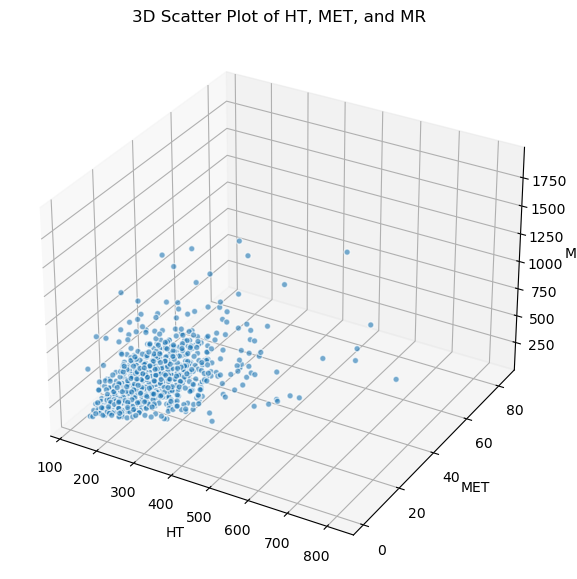

In [629]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')


sc = ax.scatter(subset_data['HT'], subset_data['MET'], subset_data['MR'],  alpha=0.6, edgecolors='w', marker='o')

ax.set_xlabel('HT')
ax.set_ylabel('MET')
ax.set_zlabel('MR')
ax.set_title('3D Scatter Plot of HT, MET, and MR')

plt.show()


In [630]:
BASE_LENGTH = 10
POPULATION_SIZE = 100

Q1_HT = dataset['HT'].quantile(0.25)
Q3_HT = dataset['HT'].quantile(0.75)
Q1_MET = dataset['MET'].quantile(0.25)
Q3_MET = dataset['MET'].quantile(0.75)

IQR_HT = Q3_HT - Q1_HT
IQR_MET = Q3_MET - Q1_MET

multiplier = 1.0
lower_bound_HT = Q1_HT - multiplier * IQR_HT
upper_bound_HT = Q3_HT + multiplier * IQR_HT
lower_bound_MET = Q1_MET - multiplier * IQR_MET
upper_bound_MET = Q3_MET + multiplier * IQR_MET

In [631]:
def calculate_outlierness(individual):
    index = int(''.join(map(str, individual)), 2)
    index = index % len(dataset)

    HT_val = dataset['HT'].iloc[index]
    MET_val = dataset['MET'].iloc[index]

    outlierness = 0
    if HT_val < lower_bound_HT or HT_val > upper_bound_HT:
        outlierness += 1
    if MET_val < lower_bound_MET or MET_val > upper_bound_MET:
        outlierness += 1

    return outlierness,

In [632]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, BASE_LENGTH)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", calculate_outlierness)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

/Users/rohanarni/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/rohanarni/anaconda3/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [633]:
def run_ga():
    pop = toolbox.population(n=POPULATION_SIZE)
    NGEN = 50
    CXPB, MUTPB = 0.7, 0.2

    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    for gen in range(NGEN):
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        pop[:] = offspring

    return pop

In [634]:
def decode_individual(individual):
    return int(''.join(map(str, individual)), 2) % len(dataset) # Convert the binary string to an integer

def get_outlier_data(population):
    outlier_indices = [decode_individual(ind) for ind in population if ind.fitness.values[0] > 0] # Get the indices of the outliers
    outlier_indices = list(set(outlier_indices)) # Remove duplicates
    
    return dataset.iloc[outlier_indices] # Return the outlier data

In [635]:
final_population = run_ga()
top_individuals = sorted(final_population, key=lambda x: x.fitness.values[0], reverse=True)[:5]
top_individuals

[[1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [1, 1, 1,

In [636]:
outlier_data = get_outlier_data(final_population)
number_of_outliers = outlier_data.shape[0]
number_of_outliers

1